<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
This is a notebook to describe the step by step logic of training a GP-VAE
</div>

VAEs dynamiques : https://arxiv.org/abs/2008.12595

Papiers GP-VAE :
- Deep Probabilistic Time Series Imputation https://arxiv.org/abs/1907.04155
- Gaussian Process Prior Variational Autoencoders : https://arxiv.org/abs/1810.11738
- Bayesian Gaussian Process Latent Variable Model : https://proceedings.mlr.press/v9/titsias10a/titsias10a.pdf
- Markovian Gaussian Process Variational Autoencoders : https://arxiv.org/abs/2207.05543

Imports and set up

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [129]:
import sys
import os

# Add the parent directory to sys.path to find the libs module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# print(f"Added {parent_dir} to Python path")
# print(f"Current working directory: {os.getcwd()}")
# print(f"Python path: {sys.path}")

In [130]:
from libs.gpvae_lib import seed_everything
# from libs.gpvae_lib import Encoder, GaussianDecoder, GaussianProcessPriorMaison, EncoderMean, EncoderCovariance
# from libs.gpvae_lib import DecoderMean, make_mlp, GPNullMean, GPConstantMean, compute_vlb, kl_maison
# from libs.gpvae_lib import CauchyKernel, RQKernel, MaternKernel # GaussianKernel, 
# from libs.gpvae_lib import compute_vlb

In [131]:
# Set seed for reproducibility
seed_everything(42)

In [132]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


### Synthetic data

We assume here a batch of $B$ time series, each composed of $N$ points $x \in \mathbb{R}^{D_x}$.

We will use a set of $D_z$ Gaussian Processes to encode the latent representation.

In [133]:
# Dimensions
Dx = 4
Dz = 2

# parameters
N = 200
B = 16

In [134]:
# Synthetic data
x = torch.randn((B,N,Dx)).to(device)
t = torch.linspace(0, 1, N).to(device).unsqueeze(0).repeat(B, 1)

# report
print(f"batch size: {B}")
print(f"time series length: {N}")
print(f"Dx: {Dx}, Dz: {Dz}")
print(f"x shape: {x.shape}")
print(f"t shape: {t.shape}")

batch size: 16
time series length: 200
Dx: 4, Dz: 2
x shape: torch.Size([16, 200, 4])
t shape: torch.Size([16, 200])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Generative model
</div>

In [135]:
# Utility function to create a Multi-Layer Perceptron (MLP)

def make_mlp(
    input_dim, 
    output_dim, 
    n_layers=3, 
    inter_dim=128, 
    activation=nn.ReLU):
    """Create a Multi-Layer Perceptron (MLP) with specified parameters.
    
    Args:
        input_dim (int): Dimension of the input layer.
        output_dim (int): Dimension of the output layer.
        n_layers (int, optional): Number of layers in the MLP. Defaults to 3.
            - first layer is input_dim x inter_dim
            - last layer is inter_dim x output_dim
            - all other layers are inter_dim x inter_dim
        inter_dim (int, optional): Number of neurons in the hidden layers. Defaults to 128.
        activation (nn.Module, optional): Activation function to use. Defaults to nn.ReLU.
            the last layer does not have an activation function.
        
    Returns:
        nn.Sequential: A sequential model representing the MLP.
    """
    
    layers = []
    for i in range(n_layers):
        if i == 0:
            layers.append(nn.Linear(input_dim, inter_dim))
        elif i == n_layers - 1:
            layers.append(nn.Linear(inter_dim, output_dim))
        else:
            layers.append(nn.Linear(inter_dim, inter_dim))
        
        if i < n_layers - 1:
            layers.append(activation())
    
    return nn.Sequential(*layers)

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Encoder
</div>

For a given time serie, the approximate posterior $q_{\phi}$ is a set of $D_z$ independent -but not identical- multivariate Gaussians of dimension $N$. This encodes a temporal dependency over each dimension of the latent variables, but no dependency between dimensions.

$q_{\phi}$ is a tf.distribution.MultivariateNormal object with batch_shape = $(B, D_z)$ and event_shape = $N$

\begin{align}
q_{\phi}(z_{1:N} \vert x_{1:N}) &= \mathcal{N}(\mu_{\phi}(z_{1:N} \vert x_{1:N}), \Sigma_{\phi}(z_{1:N} \vert x_{1:N}))
\end{align}

### Encoder mean

We output the mean $\mu_{\phi}(z_{1:N} \vert x_{1:N})$ of $q_{\phi}$ with a simple MLP.

The neural net takes an input tensor $(B, N, D_x)$ and outputs a tensor $(B, D_z, N)$

In [136]:
class EncoderMean(nn.Module):
    """ Neural Net to compute the mean of the Gaussian Encoder distribution.
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 3,
                 inter_dim = 128,
                 activation = nn.ReLU,
                 ):
        """_summary_

        Args:
            x_dimension (_type_, optional): Dimension des observations. Defaults to 1.
            z_dimension (_type_, optional): Dimension de l'espace latent. Defaults to 1.
            n_layers (int, optional): Nombre total de layers du MLP. Defaults to 3.
            inter_dim (int, optional): Nombre de neurones des hidden layers. Defaults to 128.
            activation (_type_, optional): Activation. Defaults to nn.ReLU. NB : la dernière couche n'a pas d'activation.
        """
        super(EncoderMean, self).__init__()
        
        assert n_layers > 0, "n_layers must be greater than 0 !"
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
                
        self.mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,  # output is a vector of length sequence_length * z_dimension
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=self.activation
        )
        
    
    def forward(self, input):
        """
        Forward pass of the EncoderMean.
        Args:
            x (torch.Tensor): Input tensor (..., N, x_dimension) (possibly N=1, ie a single point)
        Returns:
            z (torch.Tensor): Output tensor (..., z_dimension, N)
        """
        
        assert input.size(-1) == self.x_dimension, f"Wrong x_dim in EncoderMean. Input tensor must have shape (..., {self.x_dimension})"
        assert input.dim() >= 2, "Input tensor must have at least 2 dimensions (sequence_length -possibly 1- and x_dimension)"
        
        output = self.mlp(input)  # (..., N, Dz)
        output = torch.transpose(output,-1, -2)  # (..., Dz, N)
            
        return output  # (..., Dz, N) : batch of Dz independent but not identical Gaussians of dimension N. (can have N=1).
    
    def __repr__(self):
        return (f"{self.__class__.__name__}, "
                f"x_dimension={self.x_dimension}, z_dimension={self.z_dimension}, "
                f"n_layers={self.n_layers}, inter_dim={self.inter_dim}, "
                f"activation={self.activation.__name__}")

In [137]:
encoder_mean = EncoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

mu_phi = encoder_mean(x)

# report
print(f"Input shape: {x.shape}")
print(f"Output shape: {mu_phi.shape}")

Input shape: torch.Size([16, 200, 4])
Output shape: torch.Size([16, 2, 200])


### Parametrizing the Gaussian Encoder with either precision matrix or covariance matrix

We have the choice of parametrizing $q_{\phi}$ with covariance matrices, precision matrices, of Cholesky-lower triangular matrices.

Precision matrices are formed following Deep Probabilistic Time Series Imputation https://arxiv.org/abs/1907.04155 . First, a bi-band upper triangular matrix $B$ is formed as the sum of a diagonal matrix $D$ (with $D_{ii} > 0$) and a upper-band matrix $U = U_{ij}$ with $U_{ij} = u_{ij}$ if $j \in [i, i+1]$. Then the precision matrix is assembled by $\Lambda = B^TB$ (this ensures positive definitiveness)

In [138]:
# Encoder Precision

class EncoderPrecision(nn.Module):
    """Reprise de l'implémentation du papier GPVAE avec
    matrice de précision triangulaire supérieure à deux bandes
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 2,
                 inter_dim = 32,
                 activation = nn.ReLU,
                 epsilon = 1e-3
                 ):
        
        super(EncoderPrecision, self).__init__()
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
        self.epsilon = float(epsilon) 
        
        self.diagonal_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
        self.off_diagonal_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
    def forward(self, x):
        """
        x : (B, N, Dx)
        return : (B, Dz, Dz)
        """
        N = x.size(-2)
        
        # Compute the diagonal part
        D = self.diagonal_mlp(x) # (B, N, Dz)
        D = torch.transpose(D, -1, -2)  # (B, Dz, N)
        D = torch.exp(D) # ensure > 0
        D = torch.diag_embed(D) # (B, Dz, N, N)
        
        # compute the upper band
        U = self.off_diagonal_mlp(x) # (B, N, Dz)
        U = torch.transpose(U, -1, -2)  # (B, Dz, N)
        U = torch.diag_embed(U[...,:-1], offset=1)  # (B, Dz, N, N)
        
        # Combine diagonal and upper band
        B = D + U # (B, Dz, N, N)

        precision_matrix = torch.transpose(B, -1, -2) @ B  # (B, N, Dz, Dz)        
        # Add epsilon to the diagonal to ensure PSD numerical stability
        epsilon_matrix = self.epsilon * torch.eye(N, device=device) # (N, N)
        precision_matrix = precision_matrix + epsilon_matrix # (B, Dz, N, N) with epsilon broacasted
        
        return D, B, precision_matrix  # (B, Dz, N, N)
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(x_dimension={self.x_dimension}, "
                f"z_dimension={self.z_dimension}, n_layers={self.n_layers}, "
                f"inter_dim={self.inter_dim}, activation={self.activation.__name__}, "
                f"epsilon={self.epsilon})")

In [141]:
encoder_precision = EncoderPrecision(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

D, B, precision_matrix_q_phi = encoder_precision(x)

print(f"batch size = {x.size(0)}")
print(f"longueur de la séquence = {x.size(1)}")
print(f"Dimension de l'entrée x = {x.size(-1)}")
print(f"EncoderPrecision: {encoder_precision}")
print(f"x shape: {x.shape}")  # (B, N, Dx)
print(f"Batch matrices diagonales D, shape: {D.shape}")  # (B, Dz, N, N)
print(f"Batch matrices bi-bandes B, shape: {B.shape}")  # (B, Dz, N, N)
print(f"Batch matrices precision, shape: {precision_matrix_q_phi.shape}")  # (B, N, Dz, Dz)

batch size = 16
longueur de la séquence = 200
Dimension de l'entrée x = 4
EncoderPrecision: EncoderPrecision(x_dimension=4, z_dimension=2, n_layers=2, inter_dim=32, activation=ReLU, epsilon=0.001)
x shape: torch.Size([16, 200, 4])
Batch matrices diagonales D, shape: torch.Size([16, 2, 200, 200])
Batch matrices bi-bandes B, shape: torch.Size([16, 2, 200, 200])
Batch matrices precision, shape: torch.Size([16, 2, 200, 200])


Covariance matrices are formed by using the Cholesky decomposition, $C = LL^T$, with $L$ lower traingular with stricly positive entries on the diagonal.

In [142]:
# Encoder Covariance

class EncoderCovariance(nn.Module):
    """ Neural Net to compute the covariance of the Gaussian Encoder distribution.
    Uses a MLP to compute the lower triangular matrix of the Cholesky decomposition of the covariance matrix.
    L is triangular inferior, with diagonal elements strictly positive.
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 3,
                 inter_dim = 128,
                 activation = nn.ReLU,
                 epsilon = 1e-3,  # small positive constant to ensure positive definiteness of the kernel matrix
                 ):
        """_summary_

        Args:
            x_dimension (_type_, optional): Dimension des observations. Defaults to 1.
            z_dimension (_type_, optional): Dimension de l'espace latent. Defaults to 1.
            n_layers (int, optional): Nombre total de layers du MLP. Defaults to 3.
            inter_dim (int, optional): Nombre de neurones des hidden layers. Defaults to 128.
            activation (_type_, optional): Activation. Defaults to nn.ReLU. NB : la dernière couche n'a pas d'activation.
        """
        super(EncoderCovariance, self).__init__()
        
        assert n_layers > 0, "n_layers must be greater than 0 !"
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
        self.epsilon = float(epsilon)  # small positive constant to ensure positive definiteness of the kernel matrix
        
        # this network to get the diagonal elements of the covariance matrix
        self.diagonal_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
        # this network to get Dz elements that will be the lower triangular part (without the diagonal) of the covariance matrix                
        self.full_matrix_mlp = make_mlp(
            input_dim=self.x_dimension,
            output_dim=self.z_dimension,
            n_layers=self.n_layers,
            inter_dim=self.inter_dim,
            activation=activation
        )
        
    
    def forward(self, x):
        """
        Forward pass of the EncoderCovariance.
        Args:
            x (torch.Tensor): Input tensor (..., N, x_dimension) 
                - N can be 1 (ie a single point) or the sequence length. Must be specified.

        Returns:
            L (torch.Tensor): Lower triangular matrix of shape (..., z_dimension, N, N) 
                L can be used as scale_tril in tf.distributions.MultivariateNormal
            C (torch.Tensor): Covariance matrix of shape (..., z_dimension, N, N) 
                C can be used as covariance_matrix in tf.distributions.MultivariateNormal. but this creates lots of numerical instabilities.
            C is computed as L @ L^T, where L is the lower triangular matrix. (Cholesky decomposition)
        """
        
        # basic check of shape of input x
        assert x.size(-1) == self.x_dimension, f"Wrong x_dim in EncoderCovariance. Input tensor must have shape (batch_size, {self.sequence_length}, {self.x_dimension}) or ({self.sequence_length}, {self.x_dimension})"
        assert x.dim() >= 2, "Input tensor must have at least 2 dimensions (sequence_length -possibly 1- and x_dimension)"
        
        # input is a tensor of shape (..., N, Dx)
        N = x.size(-2)  # sequence length
        
        # Compute the diagonal elements of the covariance matrix
        D = self.diagonal_mlp(x)  # out : (..., N, Dz)
        D = torch.transpose(D, -1, -2)  # out : (..., Dz, N)
        D = torch.exp(D) # out : (..., Dz, N). Ensure entries > 0.
        D = torch.diag_embed(D) # shape (..., Dz, N, N)
        
        # Get the elements outside the diagonal
        M = self.full_matrix_mlp(x) # shape (..., N, Dz)
        M = torch.transpose(M, -1, -2)  # shape (..., Dz, N)
        M1 = M.unsqueeze(-1)  # shape (..., Dz, N, 1)
        M2 = M.unsqueeze(-2)  # shape (..., Dz, 1, N)
        M = torch.matmul(M1, M2)  # shape (..., Dz, N, N)
        M = torch.tril(M, diagonal=-1)  # Keep only the lower triangular part of the matrix (excluding the diagonal) (..., Dz, N, N))
        
        # Assemble the lower triangular matrix L
        L = D + M # (..., Dz, N, N)
        
        # Assemble the covariance matrix C
        C = L @ L.transpose(-1, -2)  # C = L @ L^T # (..., Dz, N, N)
        C = C + self.epsilon * torch.eye(N, device=x.device) # Add a small value to the diagonal for numerical stability (use broadcasting)
            
        return L, C # (..., Dz, N, N) Covariance matrix C
    
    def __repr__(self):
        return (f"{self.__class__.__name__} : "
                f"(x_dimension={self.x_dimension}, z_dimension={self.z_dimension}, "
                f"n_layers={self.n_layers}, inter_dim={self.inter_dim}, "
                f"activation={self.activation.__name__}, "
                f"epsilon (to ensure PSD)={self.epsilon:.3e})")

In [143]:
encoder_covariance = EncoderCovariance(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=32,
    activation=nn.ReLU,
).to(device)

L_q_phi, covariance_matrix_q_phi = encoder_covariance(x)

print(f"batch size = {x.size(0)}")
print(f"longueur de la séquence = {x.size(1)}")
print(f"Dimension de l'entrée x = {x.size(-1)}")
print(f"Encoder Covariance: {encoder_covariance}")
print(f"x shape: {x.shape}")  # (B, N, Dx)
print(f"Batch matrices triangulaires inférieures L, shape: {L_q_phi.shape}")  # (B, Dz, N, N)
print(f"Batch matrices covariance, shape: {covariance_matrix_q_phi.shape}")  # (B, N, Dz, Dz)

batch size = 16
longueur de la séquence = 200
Dimension de l'entrée x = 4
Encoder Covariance: EncoderCovariance : (x_dimension=4, z_dimension=2, n_layers=2, inter_dim=32, activation=ReLU, epsilon (to ensure PSD)=1.000e-03)
x shape: torch.Size([16, 200, 4])
Batch matrices triangulaires inférieures L, shape: torch.Size([16, 2, 200, 200])
Batch matrices covariance, shape: torch.Size([16, 2, 200, 200])


We can form the approximate posterior (encoder) with either parametrization.

In [144]:
#------- CHOIX 1 : PRECISION MATRIX -------
q_phi_p = torch.distributions.MultivariateNormal(
    loc=mu_phi,  # (Dz, N)
    precision_matrix=precision_matrix_q_phi,  # (Dz, N, N)
)

# ------- CHOIX 2 : COVARIANCE MATRIX -------
q_phi_c = torch.distributions.MultivariateNormal(
    loc=mu_phi,  # (Dz, N)
    scale_tril=L_q_phi,  # (Dz, N, N)
)

# ----- Summary de l'encoder q_phi -----
print(f"q_phi with precision matrix : {q_phi_p}")
print(f"\tq_phi batch shape: {q_phi_p.batch_shape}")
print(f"\tq_phi event shape: {q_phi_p.event_shape}")

print()
print(f"q_phi with Cholesky matrix : {q_phi_c}")
print(f"\tq_phi batch shape: {q_phi_c.batch_shape}")
print(f"\tq_phi event shape: {q_phi_c.event_shape}")

q_phi with precision matrix : MultivariateNormal(loc: torch.Size([16, 2, 200]), precision_matrix: torch.Size([16, 2, 200, 200]))
	q_phi batch shape: torch.Size([16, 2])
	q_phi event shape: torch.Size([200])

q_phi with Cholesky matrix : MultivariateNormal(loc: torch.Size([16, 2, 200]), scale_tril: torch.Size([16, 2, 200, 200]))
	q_phi batch shape: torch.Size([16, 2])
	q_phi event shape: torch.Size([200])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Decoder
</div>

By D-separation, we know that the decoder factorizes :

\begin{align}
p_{\theta_x}(x_{1:N} \vert z_{1:N}) &= \prod_{i=1}^{i=N} p_{\theta_x}(x_i \vert z_i)
\end{align}

When the decoder is chosen to be Gaussian, this is equivalent to say that $p_{\theta_x}$ is a Gaussian distribution of dimension $N$ with a diagonal covariance matrix :

\begin{align}
p_{\theta_x} (x_{1:N} \vert z_{1:N}) &= \mathcal{N}(\mu_{\theta_x}(x_{1:N} \vert z_{1:N}), \text{diag}(\sigma_x^2(x_{1:N} \vert z_{1:N})))
\end{align}

We learn $\mu_{\theta_x}$ and $\sigma_x^2$ with two MLPs.

In [145]:
class DecoderMean(nn.Module):
    """ Neural Net to compute the mean of the Gaussian Decoder distribution.
    """
    
    def __init__(self,
                 x_dimension = 1,
                 z_dimension = 1,
                 n_layers = 3,
                 inter_dim = 128,
                 activation = nn.ReLU,
                 ):
        """_summary_

        Args:
            x_dimension (_type_, optional): Dimension des observations. Defaults to 1.
            z_dimension (_type_, optional): Dimension de l'espace latent. Defaults to 1.
            n_layers (int, optional): Nombre total de layers du MLP. Defaults to 3.
            inter_dim (int, optional): Nombre de neurones des hidden layers. Defaults to 128.
            activation (_type_, optional): Activation. Defaults to nn.ReLU. NB : la dernière couche n'a pas d'activation.
        """
        super(DecoderMean, self).__init__()
        
        assert n_layers > 0, "n_layers must be greater than 0"
        
        self.x_dimension = int(x_dimension)
        self.z_dimension = int(z_dimension)
        self.n_layers = int(n_layers)
        self.inter_dim = int(inter_dim)
        self.activation = activation
        
        self.mlp = make_mlp(
            input_dim=z_dimension,
            output_dim=x_dimension,
            n_layers=n_layers,
            inter_dim=inter_dim,
            activation=activation
        )
    
    def forward(self, z):
        """
        Forward pass of the DecoderMean.
        Args:
            z (torch.Tensor): Input tensor of shape (..., z_dimension)
        Returns:
            torch.Tensor: mu_x : Output tensor of shape (..., x_dimension)
        """
              
        # mini check
        assert z.size(-1) == self.z_dimension, f"Incorrect latent dim. Input tensor z must have shape (..., {self.z_dimension})"
            
        return self.mlp(z)  # (..., Dx)
    
    def __repr__(self):
        return (f"{self.__class__.__name__} "
                f"x_dimension={self.x_dimension}, z_dimension={self.z_dimension}, "
                f"n_layers={self.n_layers}, inter_dim={self.inter_dim}, "
                f"activation={self.activation.__name__}")

In [146]:
decoder_mean = DecoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=2,
    inter_dim=16,
    activation=nn.ReLU,
).to(device)

print(decoder_mean)

z = q_phi_c.sample()  # (B, Dz, N)
print(f"z shape when sampled : {z.shape}")  # (B, Dz, N)

z = z.permute(0, 2, 1)  # (B, N, Dz) to match the decoder input shape
print(f"z shape after permutation for decoding : {z.shape}")  # (B, N, Dz)
decoder_mean_output = decoder_mean(z)  # (B, N, Dx)

print(f"decoder_mean_output shape: {decoder_mean_output.shape}")  # (B, N, Dx)

DecoderMean x_dimension=4, z_dimension=2, n_layers=2, inter_dim=16, activation=ReLU
z shape when sampled : torch.Size([16, 2, 200])
z shape after permutation for decoding : torch.Size([16, 200, 2])
decoder_mean_output shape: torch.Size([16, 200, 4])


In [147]:
decoder_logvar = make_mlp(
    input_dim=Dz,
    output_dim=Dx,
    n_layers=2,
    inter_dim=16,
    activation=nn.ReLU,
).to(device)

print(decoder_logvar)

z = q_phi_c.sample()  # (B, Dz, N)
print(f"z shape when sampled : {z.shape}")  # (B, Dz, N)
z = z.permute(0, 2, 1)  # (B, N, Dz) to match the decoder input shape
print(f"z shape after permutation for decoding : {z.shape}")  # (B, N, Dz)

decoder_logvar_output = decoder_logvar(z)  # (B, N, Dx)

print(f"decoder_logvar_output shape (ie diagonal entries): {decoder_logvar_output.shape}")  # (B, Dx, N)

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=4, bias=True)
)
z shape when sampled : torch.Size([16, 2, 200])
z shape after permutation for decoding : torch.Size([16, 200, 2])
decoder_logvar_output shape (ie diagonal entries): torch.Size([16, 200, 4])


We form the decoder with a multivariate normal distribution

In [148]:
mu_x = decoder_mean_output  # (B, N, Dx)
print(f"mu_x shape: {mu_x.shape}")  # (B, N, Dx)

logvar_x = decoder_logvar_output  # (B, N, Dx)
print(f"logvar_x shape: {logvar_x.shape}")  # (B, N, Dx)
covar_x = torch.diag_embed(logvar_x.exp())  # (B, N, Dx, Dx)
print(f"covar_x shape: {covar_x.shape} - NB : covar_x est diagonale, les x_t sont indépendants")

p_theta_x = torch.distributions.MultivariateNormal(
    loc=mu_x,
    covariance_matrix=covar_x
)

print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}") # (B, N)
print(f"\tp_theta_x event shape: {p_theta_x.event_shape}") # (Dx,)

mu_x shape: torch.Size([16, 200, 4])
logvar_x shape: torch.Size([16, 200, 4])
covar_x shape: torch.Size([16, 200, 4, 4]) - NB : covar_x est diagonale, les x_t sont indépendants
p_theta_x: MultivariateNormal(loc: torch.Size([16, 200, 4]), covariance_matrix: torch.Size([16, 200, 4, 4]))
	p_theta_x batch shape: torch.Size([16, 200])
	p_theta_x event shape: torch.Size([4])


We will actually instantiate several ($K$) distributions $p_{\theta_x}$ by sampling $K$ times $z_{1:N}$, so we can average the reconstruction loss.

In [149]:
K = 5  # Number of samples to average the reconstruction loss
z_sampled = q_phi_c.sample((K,))  # (K, B, Dz, N)
print(f"z shape when sampled {K} times : {z_sampled.shape}")  # (K, B, Dz, N)
z_sampled_p = z_sampled.transpose(-1, -2)
print(f"z shape after permutation for decoding mean : {z_sampled_p.shape}")  # (K, B, N, Dz)

mu_x = decoder_mean(z_sampled_p)  # (K, B, N, Dx)
print(f"mu_x shape: {mu_x.shape}")  # (K, B, N, Dx)

logvar_x = decoder_logvar(z_sampled_p)  # (K, B, N, Dx)
covar_x = torch.diag_embed(logvar_x.exp())  # (K, B, N, Dx, Dx)
print(f"logvar_x shape: {logvar_x.shape}")  # (K, B, N, Dx)
print(f"covar_x shape: {covar_x.shape} - NB : covar_x est diagonale, les x_t sont indépendants")  # (K, B, N, Dx, Dx)

p_theta_x = torch.distributions.MultivariateNormal(
    loc=mu_x,
    covariance_matrix=covar_x
)

print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")  # (K, B, N)
print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")  # (Dx,)

z shape when sampled 5 times : torch.Size([5, 16, 2, 200])
z shape after permutation for decoding mean : torch.Size([5, 16, 200, 2])
mu_x shape: torch.Size([5, 16, 200, 4])
logvar_x shape: torch.Size([5, 16, 200, 4])
covar_x shape: torch.Size([5, 16, 200, 4, 4]) - NB : covar_x est diagonale, les x_t sont indépendants
p_theta_x: MultivariateNormal(loc: torch.Size([5, 16, 200, 4]), covariance_matrix: torch.Size([5, 16, 200, 4, 4]))
	p_theta_x batch shape: torch.Size([5, 16, 200])
	p_theta_x event shape: torch.Size([4])


In [150]:
print(f"One covariance matrix for one x_t: ")
print(f"{covar_x[0,0,0]}")  # (Dx, Dx)

One covariance matrix for one x_t: 
tensor([[0.8053, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0893, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.3047, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6309]], device='cuda:0',
       grad_fn=<SelectBackward0>)


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Gaussian Process priors
</div>

Each dimension $l$ of the latent variables (with $1 \leq l \leq D_z$) has a Gaussian Process prior over times:

\begin{align}
z_l \sim \mathcal{GP}(m_l(.), k_l(.,.))
\end{align}

Where the mean functions $m_l$ (usually constant null) and kernel functions $k_l(.,.)$ are a priori different along the dimensions. The kernel functions can either be fixed, or have learnable parameters, and encode the prior knowledge (if any) regarding the time series.

Gaussian Kernel class with learnable parameters

In [151]:
class GaussianKernel(nn.Module):  
    """Gaussian kernel for one univariate Gaussian Process.
    The lengthscale and variance parameters are learnable (nn.Parameter).
    """
    
    # we need to add a small positive constant to ensure positive definiteness of the kernel matrix
    # 1e-3 is ok for time series up to 10,000 time points.
    # 1e-4 is ok for time series up to 2,880 time points. (ie 2 days @ 1 minute resolution).
    # 1e-4 is ok for time series up to 1,000 time points.
    # 1e-6 is ok for time series up to 100 time points.
    # the value can be decreased for shorter time series.
    # but it should not be too small, otherwise the Cholesky decomposition will fail.
    
    def __init__(self, lengthscale=1.0, sigma=1.0, epsilon=1e-3):
        super(GaussianKernel, self).__init__()
        
        # learnable parameters for the Gaussian kernel
        self.lengthscale = nn.Parameter(torch.tensor(lengthscale))  # learnable lengthscale parameter       
        self.sigma = nn.Parameter(torch.tensor(sigma))  # learnable variance parameter
        
        self.epsilon = torch.tensor(epsilon)  # tolerance to ensure positive definiteness of the kernel matrix
    
    def forward(self, t1, t2):
        """Compute the Gaussian kernel between two sets of time points.
        
        Args:
            t1 (torch.Tensor): First set of time points (..., N) - N is typically the sequence length.
            t2 (torch.Tensor): Second set of time points (..., M)
        
        Returns:
            torch.Tensor: Kernel matrix of shape (..., N, M)
        """
        
        assert t1.dim() == t2.dim(), "GaussianKernel object : Input tensors must have the same number of dimensions"
        
        # Compute the Gaussian kernel matrix
        if t1.dim() == 1:
            t1_b = t1.unsqueeze(-1)  # (N, 1)
            t2_b = t2.unsqueeze(0)   # (1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (N, M)
        else:
            t1_b = t1.unsqueeze(-1) # (...,N, 1)
            t2_b = t2.unsqueeze(-2) # (...,1, M)
            kernel = torch.exp(-0.5 * ((t1_b - t2_b) / self.lengthscale)**2)  # (..., N, M)
        
        gaussian_kernel_matrix = self.sigma**2 * kernel  # (..., N, M)

        if torch.equal(t1, t2):
            # If t1 and t2 are the same, the kernel matrix should be symmetric and positive definite
            # so we compute and return the Cholesky decomposition of the kernel matrix
            # to be used in forming the MultivariateNormal distribution, adding
            # a small value to the diagonal for numerical stability
            gaussian_kernel_matrix = gaussian_kernel_matrix + self.epsilon * torch.eye(t1.size(-1), device=t1.device, dtype=t1.dtype)

            try:
                L = torch.linalg.cholesky(gaussian_kernel_matrix)  # Cholesky decomposition to ensure positive definiteness
                return gaussian_kernel_matrix, L  # Return the kernel matrix and its Cholesky factor L
            
            except RuntimeError:
                # If the Cholesky decomposition fails, it means the matrix is not positive definite
                # We can return None or raise an error, depending on how we want to handle this case
                # print("Warning: Cholesky decomposition failed.")
                # print(f"Kernel : {gaussian_kernel_matrix}")
                # return gaussian_kernel_matrix, None  # Return the kernel matrix and None for L
                raise NameError("Cholesky decomposition of a supposedly PSD kernel matrix failed. Tolerance alpha is likely too low.") 
            
        else:
            # If t1 and t2 are different, do not try to compute the Cholesky decomposition
            return gaussian_kernel_matrix, None
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(lengthscale={self.lengthscale.item():.3e}, "
                f"variance (sigma**2)={self.sigma.item()**2:.3e}, "
                f"sigma={self.sigma.item():.3e}, "
                f"epsilon={self.epsilon.item():.3e})")      

Matern Kernel class with learnable parameters

In [152]:
class MaternKernel(nn.Module):
    """Matern kernel for one univariate Gaussian Process.
    Takes nu = 0.5, 1.5, 2.5 in the constructor.
    The lengthscale, variance and alpha parameters are learnable (nn.Parameter).
    """
    
    def __init__(self, nu, lengthscale=1.0, sigma=1.0, epsilon=1e-3):
        super(MaternKernel, self).__init__()
        
        # check
        if nu not in [0.5, 1.5, 2.5]:
            raise ValueError("MaternKernel: nu must be one of [0.5, 1.5, 2.5]")
        self.nu = nu  # Matern parameter nu
        
        # learnable parameters for the RQ kernel
        self.lengthscale = nn.Parameter(torch.tensor(lengthscale))  # learnable alpha parameter (shape parameter)
        self.sigma = nn.Parameter(torch.tensor(sigma))  # learnable variance = sigma**2 parameter

        self.epsilon = epsilon  # small value to ensure positive definiteness of the kernel matrix
    
    def forward(self, t1, t2):
        """Compute the Matern kernel between two sets of time points.
        
        Args:
            t1 (torch.Tensor): First set of time points (..., N) - N is typically the sequence length.
            t2 (torch.Tensor): Second set of time points (..., M)
        
        Returns:
            torch.Tensor: Kernel matrix of shape (..., N, M)
        """
        
        assert t1.dim() == t2.dim(), "Matern Kernel object : Input tensors must have the same number of dimensions"
        
        if t1.dim() == 1:
            t1_b = t1.unsqueeze(-1)  # (N, 1)
            t2_b = t2.unsqueeze(0)   # (1, M)
        else:
            t1_b = t1.unsqueeze(-1) # (..., N, 1)
            t2_b = t2.unsqueeze(-2) # (..., 1, M)
        
        d = torch.abs(t1_b - t2_b)  # (..., N, M)
        
        if self.nu == 0.5:
            # Matern kernel with nu = 0.5
            matern_kernel = self.sigma**2 * torch.exp(-d / self.lengthscale)
        elif self.nu == 1.5:
            # Matern kernel with nu = 1.5
            matern_kernel = self.sigma**2 * (1 + (d * torch.sqrt(torch.tensor(3))) / self.lengthscale) * torch.exp(-d * torch.sqrt(torch.tensor(3)) / self.lengthscale)
        elif self.nu == 2.5:
            # Matern kernel with nu = 2.5
            matern_kernel = self.sigma**2 * (1 + ((d * torch.sqrt(torch.tensor(5))) / self.lengthscale) + (5 * d**2 / (3 * self.lengthscale**2))) * torch.exp(-d * torch.sqrt(torch.tensor(5)) / self.lengthscale)
        else:
            raise ValueError("MaternKernel: nu must be one of [0.5, 1.5, 2.5]")

        if torch.equal(t1, t2):
            # If t1 and t2 are the same, the kernel matrix should be symmetric and positive definite
            # so we compute and return the Cholesky decomposition of the kernel matrix
            # to be used in forming the MultivariateNormal distribution, adding
            # a small value to the diagonal for numerical stability
            matern_kernel += self.epsilon * torch.eye(t1.size(-1), device=t1.device, dtype=t1.dtype)
            try:
                L = torch.linalg.cholesky(matern_kernel)  # Cholesky decomposition to ensure positive definiteness
                return matern_kernel, L  # Return the kernel matrix and its Cholesky factor L
            except RuntimeError:
                # If the Cholesky decomposition fails, it means the matrix is not positive definite
                # We can return None or raise an error, depending on how we want to handle this case
                # print("Warning: Cholesky decomposition failed.")
                # print(f"Kernel : {gaussian_kernel_matrix}")
                # return gaussian_kernel_matrix, None  # Return the kernel matrix and None for L
                raise NameError("Cholesky decomposition of a supposedly PSD kernel matrix failed in Matern Kernel. Tolerance epsilon is likely too low.") 
        else:
            # If t1 and t2 are different, do not try to compute the Cholesky decomposition
            return matern_kernel, None
    
    def __repr__(self):
        return (f"{self.__class__.__name__}(nu={self.nu}, "
                f"lengthscale={self.lengthscale.item():.3e}, "
                f"sigma={self.sigma.item():.3e}, "
                f"variance (sigma**2)={self.sigma.item()**2:.3e}, "
                f"epsilon={self.epsilon:.3e})")

Null mean function class

In [153]:
class GPNullMean(nn.Module):
    """ Neural Net to compute the mean of one univariate Gaussian Process
    This is a null mean function, i.e. it returns a tensor of zeros...
    """
    
    def __init__(self):
        super(GPNullMean, self).__init__()
    
    def forward(self, t):
        """Forward pass of the GPNullMean.
        Just returns a tensor of zeros of shape identical to the input.
        
        Inputs:
            t (torch.Tensor): Input tensor of shape (..., N) - N is typically the sequence length.
        Returns:
            torch.Tensor: Output tensor of ZEROS of shape (..., N)
        """
        
        return torch.zeros_like(t, dtype=t.dtype, device=t.device)  # (..., N)
    
    def __repr__(self):
        return f"{self.__class__.__name__}"

We assemble the $D_z$ Gaussian Process priors, for example with kernels with different lengthscales.

In [154]:
kernels_list = []
mean_functions_list = []

for i in range(Dz):
    kernel = GaussianKernel(lengthscale=1 / 2**i, sigma=1.0, epsilon=1e-12)
    kernels_list.append(kernel)
    mean_function = GPNullMean()
    mean_functions_list.append(mean_function)

In [155]:
kernel_matrices = []
L_matrices = []
means = []

for i in range(Dz):
    print()
    print(f"Computing Gaussian Process prior {i+1} / {Dz}...")
    print(f"Kernel {i}: {kernels_list[i]}")
    print(f"Mean function {i}: {mean_functions_list[i]}")
    
    mu_z_i = mean_functions_list[i](t)  # (B, N)
    print(f"mu_z_i shape: {mu_z_i.shape}")  # (B, N)
    kernel_matrix_i, L_i = kernels_list[i](t, t)
    print(f"Kernel matrix {i} shape: {kernel_matrix_i.shape}")  # (B, N, N)
    
    kernel_matrices.append(kernel_matrix_i)  # (B, N, N)
    L_matrices.append(L_i)  # (B, N, N) or None
    means.append(mu_z_i)  # (B, N)
    
print()
kernel_matrix = torch.stack(kernel_matrices, dim=0)  # (Dz, B, N, N)
kernel_matrix = kernel_matrix.transpose(0, 1) # (B, Dz, N, N)
print(f"Kernel matrix shape after transpose: {kernel_matrix.shape}")  # (Dz, B, N, N)
L_matrix = torch.stack(L_matrices, dim=0) if L_matrices[0] is not None else None  # (Dz, B, N, N) or None
L_matrix = L_matrix.transpose(0, 1) if L_matrix is not None else None  # (B, Dz, N, N)
print(f"L matrix shape after transpose: {L_matrix.shape if L_matrix is not None else 'None'}")  # (B, Dz, N, N) or None
mean = torch.stack(means, dim=0)  # (Dz, B, N)
mean = mean.transpose(0, 1)  # (B, Dz, N)
print(f"Mean shape after transpose: {mean.shape}")  # (B, Dz, N)



Computing Gaussian Process prior 1 / 2...
Kernel 0: GaussianKernel(lengthscale=1.000e+00, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-12)
Mean function 0: GPNullMean
mu_z_i shape: torch.Size([16, 200])
Kernel matrix 0 shape: torch.Size([16, 200, 200])

Computing Gaussian Process prior 2 / 2...
Kernel 1: GaussianKernel(lengthscale=5.000e-01, variance (sigma**2)=1.000e+00, sigma=1.000e+00, epsilon=1.000e-12)
Mean function 1: GPNullMean
mu_z_i shape: torch.Size([16, 200])
Kernel matrix 1 shape: torch.Size([16, 200, 200])

Kernel matrix shape after transpose: torch.Size([16, 2, 200, 200])
L matrix shape after transpose: torch.Size([16, 2, 200, 200])
Mean shape after transpose: torch.Size([16, 2, 200])


And instantiate $p_{\theta_z}$

In [156]:
p_theta_z = torch.distributions.MultivariateNormal(
    loc=mean,  # (B, Dz, N)
    scale_tril=L_matrix,  # (B, Dz, N, N)
)

print(f"p_theta_z: {p_theta_z}")
print(f"\tp_theta_z batch shape: {p_theta_z.batch_shape}")  # (B, Dz)
print(f"\tp_theta_z event shape: {p_theta_z.event_shape}")  # (N)

p_theta_z: MultivariateNormal(loc: torch.Size([16, 2, 200]), scale_tril: torch.Size([16, 2, 200, 200]))
	p_theta_z batch shape: torch.Size([16, 2])
	p_theta_z event shape: torch.Size([200])


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Computing the loss
</div>

The loss is

\begin{align}
\mathcal{L}(\theta_x, \theta_z, \phi, x_{1:N}) &= \sum_{i=1}^N \mathbb{E}_{z_i \sim q_{\phi}(z_i \vert x_{1:N})} \log{p_{\theta_x}(x_i \vert z_i)} - \sum_{l=1}^{D_z} \mathbb{KL} ( q_{\phi}(z_l \vert x_{1:N}) \vert\vert p_{\theta_z}(z_{l,1:N})) 
\end{align}

In [157]:
reconstruction_loss = -p_theta_x.log_prob(x)  # (K, B, N)
print(f"Reconstruction loss tensor shape: {reconstruction_loss.shape}")  # (K, B, N)

rec_loss = reconstruction_loss.sum(-1)  # Sum over the sequence length N
rec_loss = rec_loss.mean()  # Average over the batch size B and the K samples

kl = torch.distributions.kl_divergence(q_phi_c, p_theta_z)  # (B, Dz)
print(f"KL divergence tensor shape: {kl.shape}")  # (B, Dz)

kl_loss = kl.sum(-1)  # Sum over the dimensions Dz
kl_loss = kl_loss.mean()  # Average over the batch size B

print(f"KL = {kl_loss.item():.4e}, reconstruction = {rec_loss.item():.4e}, total loss = {(kl_loss + rec_loss).item():.4e}")

Reconstruction loss tensor shape: torch.Size([5, 16, 200])
KL divergence tensor shape: torch.Size([16, 2])
KL = 3.5777e+14, reconstruction = 1.2787e+03, total loss = 3.5777e+14


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Data
</div>

We will create $Dx$ time series over $N$ points

In [158]:
# Dimensions
Dx = 4
Dz = 2

# parameters
N = 200
B = 16

Input shape: torch.Size([16, 200, 4])


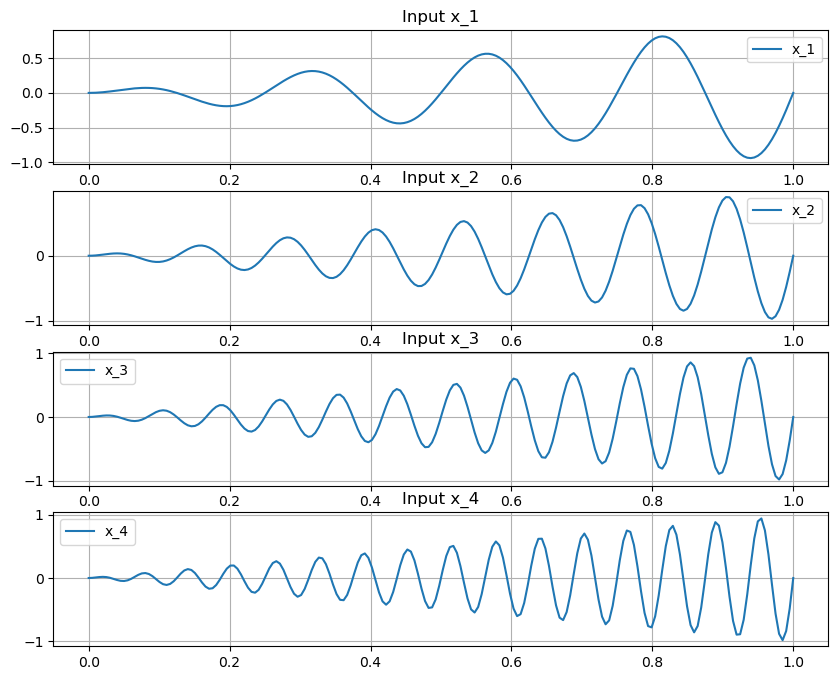

In [162]:
t = torch.linspace(0, 1, N).to(device)
xs = [ t * torch.sin(2 * torch.pi * t * (4*(i+1))) for i in range(Dx) ]
x = torch.stack(xs, dim=-1)  # (N, Dx)
x = x.unsqueeze(0).repeat(B, 1, 1)  # (B, N, Dx)

print(f"Input shape: {x.shape}")  # (B, N, Dx)

fig, axs = plt.subplots(Dx, 1, figsize=(10, 2 * Dx))
for i in range(Dx):
    axs[i].plot(t.cpu().numpy(), x[0, :, i].cpu().numpy(), label=f"x_{i+1}")
    axs[i].set_title(f"Input x_{i+1}")
    axs[i].legend()
    axs[i].grid()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Training : A ECRIRE
</div>

Encoder

$q_\phi (z_{1:N} \vert x_{1:N})$ est une Gaussienne multivariée de dimension $N$ égale à la longueur de la time série.

In [ ]:
# vecteur moyenne de q_phi
mu_phi = encoder_mean(x_ext)  # (B, Dz, N)
mu_phi = mu_phi.squeeze(0)  # (Dz, N)

# on a deux possibilités pour obtenir la matrice de covariance de q_phi

#------- CHOIX 1 : PRECISION MATRIX -------
# # 1- calculer la matrice de précision en passant par une matrice bi-bandes traingulaire supérieure
# # (encoder_precision)
# _, _, precision_phi = encoder_precision(x_ext)  # (B, Dz, N, N)
# precision_phi = precision_phi.squeeze(0)  # (Dz, N, N)

# q_phi = torch.distributions.MultivariateNormal(
#     loc=mu_phi,  # (Dz, N)
#     precision_matrix=precision_phi,  # (Dz, N, N)
# )


# ------- CHOIX 2 : COVARIANCE MATRIX -------
# ou calculer une matrice de covariance en assemblant une triangulaire inférieure L
# et en calculant L @ L.T (Cholesky decomposition)
L_phi, covariance_phi = encoder_covariance(x_ext)  # (B, Dz, N, N)
covariance_phi = covariance_phi.squeeze(0)  # (Dz, N, N)
L_phi = L_phi.squeeze(0)  # (Dz, N, N)

q_phi = torch.distributions.MultivariateNormal(
    loc=mu_phi,  # (Dz, N)
    scale_tril=L_phi,  # (Dz, N, N)
)

# ----- Summary de l'encoder q_phi -----
print(f"mu_phi shape: {mu_phi.shape}")
print(f"sigma_phi shape: {q_phi.covariance_matrix.shape}")
print(f"q_phi: {q_phi}")
print(f"\tq_phi batch shape: {q_phi.batch_shape}")
print(f"\tq_phi event shape: {q_phi.event_shape}")

In [ ]:
# mu_phi, sigma_phi, _ = encoder(x_ext)

# mu_phi = mu_phi.squeeze(0)  # (B, N, Dz)
# sigma_phi = sigma_phi.squeeze(0)  # (B, N, Dz)

# q_phi = torch.distributions.MultivariateNormal(
#     loc=mu_phi,  # (B, N, Dz)
#     covariance_matrix=sigma_phi,  # (B, N, Dz, Dz)
# )

# print(f"mu_phi shape: {mu_phi.shape}")
# print(f"sigma_phi shape: {sigma_phi.shape}")
# print(f"q_phi: {q_phi}")
# print(f"\tq_phi batch shape: {q_phi.batch_shape}")
# print(f"\tq_phi event shape: {q_phi.event_shape}")

Sample K latent variables

In [ ]:
# number of latent variables to sample from q_phi

K = 100

In [ ]:
z_sampled = q_phi.rsample((K,))  # (K, B, N)
print(f"z_sampled shape: {z_sampled.shape}")
z_sampled_ext = z_sampled.unsqueeze(-1)  # (K, B, N, Dz)
print(f"z_sampled_ext shape: {z_sampled_ext.shape}")

Each sampled z is used to instantiate independent -and not identical !- $p_{\theta_x}$

In [ ]:
# K = 10 # number of samples to draw from the decoder distribution
# x_sampled = p_theta_x.rsample((K,))  # (K, B, L, Dx)
# print(f"x_samples shape ({K} samples): {x_sampled.shape}")

Compute the Gaussian Process prior at times t's. $p_{\theta_z}$ is a Gaussian Process, ie a multivariate Gaussian for times t's.

In [ ]:
mu_z = prior_mean(t)  # (1, N, Dz)
sigma_z, L_z = prior_kernel(t, t)  # (1, N, N)

p_theta_z = torch.distributions.MultivariateNormal(
    loc=mu_z,  # (N, Dz)
    scale_tril=L_z  # (N, N)
)

print(f"mu_z shape: {mu_z.shape}")
print(f"sigma_z shape: {sigma_z.shape}")
print(f"p_theta_z: {p_theta_z}")
print(f"\tp_theta_z batch shape: {p_theta_z.batch_shape}")
print(f"\tp_theta_z event shape: {p_theta_z.event_shape}")

Compute the metrics and the loss

In [ ]:
kl = torch.distributions.kl_divergence(q_phi, p_theta_z)  # (B, N)
print(f"kl shape: {kl.shape}")

# compute the reconstruction loss of x with each of the K sampled p_theta_x
reco_loss = -p_theta_x.log_prob(x)  # (K, 1)
print(f"reco_loss shape: {reco_loss.shape}")

loss = - reco_loss.mean() + kl.mean()  # (B, N)
# print(f"loss shape: {loss.shape}")
print(f"loss: {loss.item():.4e}")

In [ ]:
# Alternative home-made way to compute the VLB

kl_divergence_torch, kl_divergence_analytique, reconstruction_loss, vlb_value = compute_vlb(
    q_phi, p_theta_x, p_theta_z, x
)

loss = -vlb_value
print(f"Loss : {loss.item():.4e}")

# Full Training Loop

## Très grande sensibilité au lengthscale !!

Résultats :
- N = 30, l = 0.1, 1000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 100, l = 0.1, 1000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 150, l = 0.1, 1000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok !
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation ReLU sur EncoderMean, activation Tanh sur EncoderPrecision : nok !
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation ReLU sur EncoderPrecison, activation Tanh sur EncoderMean : instable, marche au 3e run, peu reproductible.
- N = 200, l = entre 0.1 et 0.14, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256, activation Tanh : ok ! NE MARCHE PAS EN DEHORS DE CET INTERVALLE DE LENGTHSCALE
- N = 200, l = 0.1, 5000 epochs, Gaussian Kernel, lr = 1e-3, 4x256 avec Encoder Ben (lower triangular pour covariance Decoder), activation Tanh : ok ! Semble moins bon malgré tout qu'avec le bi-bande. Ne marche qu'avec l <= 0.12
- pas trouvé de set up qui marche avec RQ Kernel

Toujours avec N=200, l=0.10, 5000 epochs, GK, lr=1e-3, activation Tanh - on change le réseau Encoder Mean et Encoder Precision:
- 4 layers x 256 : ok
- 2 x 64 : nok
- 4 x 64 : nok
- 4 x 128 : nok
- EncoderPrecision 4x256, EncoderMean 2x32 : ok, mais moins bon qu'avec 4x256 et 4x256
- Precision 4x256, Mean 4x32 : nok !
- Precison 4x256, Mean 4x64 : nok !
- Precision 4x256, Mean 4x128 : nok !
- Precision 4x512, Mean 4x512 : ok, semble clipper vers les +/-1 (effet Tanh ?)

Toujours avec N=200, l=0.10, GK, lr=1e-3, activation Tanh, (4x256)x2 :
- 100 epochs : nok
- 1000 epochs : ça commence !
- 2000 epochs : idem 1000
- 3000 epochs : mieux...
- 4000 epochs : très bien, tb reconstruction - loss finale : 2.126e+7 (kl 2.1262e+7, reco -4.31e+2)
- 10000 epochs : moins bien ! - loss finale = 8.83e+5, kl = 8.83e+5, reco = -1.15e+2 : reconstruction instable, moins bonne à l'arrêt aux 10000 epochs.
- 100000 epochs : instabilités. Pas de reconstruction. - loss finale = 2.46e+2, kl = 3.04e+2, reco = -5.85e+1.

Changement de fonction : t sin (2 t²) par exemple => fail. Pb quand le lengthscale change.

Très grande sensibilité à l'initialisation. Résultats peu reproductibles. 

Gros bruit dans la reconstruction_loss. Essais avec K samples de $p_{\theta_x}$ : un peu moins de bruit, mais pas de meilleurs résultats. L'erreur de reconstruction semble attaindre un plancher. NB : prendre un PETIT décodeur (ie qui ne va pas underfitter ! par exemple 4 layers x 16 pour N = 200 points)

# Gros BreakThrough : PETIT décodeur, évite l'underfitting

MEILLEURS RESULTATS : N=200, FixedGaussianKernel l=0.1, lr=1e-3, EncoderMean (4x256,nn.Tanh), EncoderPrecision(4x256,nn.Tanh), DecoderMean (4x16,nn.ReLU), Decoder_logvar (4x16,nn.Tanh), 500 epochs, K=100,10 ou même 5 samples de $p_{\theta_x}$

LEARNABLE GAUSSIAN KERNEL : marche très bien ! Apprend -dans une certaine mesure- le bon lengthscale (si l de départ pas trop éloigné de la valeur optimale). Avec décoder light (4x16,mean=nn.ReLU, covar=nn.Tanh)

Assemblage des matrices de covariance : la bi-bande traingulaire supérieure et Cholesky-based marchent bien.

Tous les Kernels fonctionnent !

In [ ]:
# encoder = Encoder(
#     x_dimension=Dx,
#     z_dimension=Dz,
#     n_layers=4,
#     inter_dim=256,
#     activation=nn.Tanh,
#     epsilon=1e-12,
# ).to(device)

# print(encoder)
# print()

encoder_mean = EncoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh,
).to(device)

print(encoder_mean)

encoder_precision = EncoderPrecision(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh, 
    epsilon=1e-12
).to(device)

print(encoder_precision)

encoder_covariance = EncoderCovariance(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=256,
    activation=nn.Tanh,
    epsilon=1e-12
).to(device)

print(encoder_covariance)

decoder_mean = DecoderMean(
    x_dimension=Dx,
    z_dimension=Dz,
    n_layers=4,
    inter_dim=16,
    activation=nn.ReLU,
).to(device)

print(decoder_mean)

decoder_logvar = make_mlp(
    input_dim=N,
    output_dim=N,
    n_layers=4,
    inter_dim=16,
    activation=nn.Tanh,
).to(device)

print(f"Decoder log variance MLP: {decoder_logvar}")
# print(decoder_logvar)

print()

# --- Prior mean ---------------------------------
# prior_mean = GPNullMean()


prior_mean = GPConstantMean(
    constant_init=1.0
)
print(prior_mean)


# --- choose your kernel carefully -----------------------------

prior_kernel = GaussianKernel(
    lengthscale=0.065,
    sigma=0.5,
    epsilon=1e-3
)

print(prior_kernel)

# prior_kernel = FixedRQKernel(
#     epsilon=1e-12,  # small value to ensure positive definiteness of the kernel matrix
#     alpha=0.5,
#     beta=10.0,
#     sigma=1.0,
# )
# print(prior_kernel)

# prior_kernel = CauchyKernel(
#     lengthscale=0.1,
#     sigma=1.0,
#     epsilon=1e-12
# )
# print(prior_kernel)

# prior_kernel = RQKernel(
#     alpha = 1.0,
#     beta = 1.0e+2,
#     sigma = 1.0,
#     epsilon = 1e-12
# )
# print(prior_kernel)

# prior_kernel = MaternKernel(
#     nu=2.5,
#     lengthscale=0.1,
#     sigma=1.0,
#     epsilon=1e-12
# )
# print(prior_kernel)

x_ext = x.unsqueeze(-1)  # (B, N, Dx)
print(f"x_ext shape: {x_ext.shape}")  # (1, N, 1)

In [ ]:
N_EPOCHS = int(5e+2)

K = 10

# NB : list(prior_kernel.parameters()) is empty since FixedGaussianKernel has no learnable parameters
# optimizer = torch.optim.Adam(
#     list(encoder.parameters()) + list(decoder_mean.parameters()) + list(decoder_logvar.parameters()) +
#     list(prior_mean.parameters()) + list(prior_kernel.parameters()),
#     lr = 1e-3
# )

optimizer = torch.optim.Adam(
    list(encoder_mean.parameters()) + list(encoder_precision.parameters()) + 
    list(encoder_covariance.parameters()) + list(decoder_mean.parameters()) + 
    list(decoder_logvar.parameters()) +
    list(prior_mean.parameters()) + list(prior_kernel.parameters()),
    lr = 1e-3
)

In [ ]:
losses = []
kls = []
reconstruction_losses = []

# dictionnary to store the parameters
mean_params = {}  # to store mean parameters if any
for name, param in prior_mean.named_parameters():
    mean_params[name] = []
    
kernel_params = {}  # to store kernel parameters if any
for name, param in prior_kernel.named_parameters():
    kernel_params[name] = []

In [ ]:
if len(list(prior_kernel.parameters())) == 0:
    learnable_kernel = False
    print("Prior kernel is fixed (no learnable parameters).")
else:
    learnable_kernel = True
    print("Prior kernel is learnable (has learnable parameters).")
    
# prior
mu_z = prior_mean(t)  # (1, N, Dz)
sigma_z, L_z = prior_kernel(t, t)  # (1, N, N)

p_theta_z = torch.distributions.MultivariateNormal(
        loc=mu_z,  # (N, Dz)
        scale_tril=L_z  # (N, N)
    )

N = t.size(-1)  # number of time points
epsilon = 1e-12
tolerance = epsilon * torch.eye(N).to(device)

for epoch in range(N_EPOCHS):
       
    # if the kernel is learnable, we need to recompute the prior mean and kernel at each epoch
    if learnable_kernel:
        mu_z = prior_mean(t)  # (1, N, Dz)
        sigma_z, L_z = prior_kernel(t, t)  # (1, N, N)

        p_theta_z = torch.distributions.MultivariateNormal(
                loc=mu_z,  # (N, Dz)
                scale_tril=L_z  # (N, N)
            )

    # ENCODERGenerative model
    # encode mean
    mu_phi = encoder_mean(x_ext)  # (B, Dz, N)
    mu_phi = mu_phi.squeeze(0)  # (N, Dz)
    
    # # choice 1 : with precision matrix
    # _, _, precision_phi = encoder_precision(x_ext)  # (B, Dz, N, N)
    # precision_phi = precision_phi.squeeze(0)  # (N, Dz, Dz)

    # q_phi = torch.distributions.MultivariateNormal(
    #     loc=mu_phi,  # (B, N, Dz)
    #     precision_matrix=precision_phi,  # (B, N, Dz, Dz)
    # )
    
    # choice 2 : with covariance matrix
    L_phi, covariance_phi = encoder_covariance(x_ext)  # (B, Dz, N, N)
    covariance_phi = covariance_phi.squeeze(0)  # (Dz, N, N)
    L_phi = L_phi.squeeze(0)  # (Dz, N, N)

    q_phi = torch.distributions.MultivariateNormal(
        loc=mu_phi,  # (Dz, N)
        scale_tril=L_phi,  # (Dz, N, N)
)
    # mu_phi, sigma_phi, _ = encoder(x.unsqueeze(-1))

    # mu_phi = mu_phi.squeeze(0)  # (B, N, Dz)
    # sigma_phi = sigma_phi.squeeze(0)  # (B, N, Dz)

    # q_phi = torch.distributions.MultivariateNormal(
    #     loc=mu_phi,  # (B, N, Dz)
    #     covariance_matrix=sigma_phi,  # (B, N, Dz, Dz)
    # )
    
    # sample z
    z_sampled = q_phi.rsample((K,)) # (K, B, N) as Dz=1
    
    # decode
    mu_x = decoder_mean(z_sampled.unsqueeze(-1))  # (K, B, N, Dx)
    mu_x = mu_x.squeeze(-1)  # (K, B, N)

    logvar_x = decoder_logvar(z_sampled)  # (K, B, N)
    covar_x = torch.diag_embed(logvar_x.exp()) # + tolerance # (K, B, N, N)

    p_theta_x = torch.distributions.MultivariateNormal(
        loc=mu_x,
        covariance_matrix=covar_x
    ) # batch_shape=(K, B), event_shape=(N,)
       
    # compute loss
    kl = torch.distributions.kl_divergence(q_phi, p_theta_z).sum(-1).mean()  # (B, N) => scalar
    reconstruction_loss = p_theta_x.log_prob(x).sum(-1).mean() # (K, B, N) => scalar
    loss = -reconstruction_loss + kl  # (B, N)

    # kl, kl_divergence_analytique, reconstruction_loss, vlb_value = compute_vlb(
    #     q_phi, p_theta_x, p_theta_z, x
    # )    
        
    # optimization step
    optimizer.zero_grad()
    loss.backward()  
    optimizer.step()
    
    # log losses
    losses.append(loss.item())
    kls.append(kl.mean().item())
    reconstruction_losses.append(-reconstruction_loss.mean().item())
    
    # record parameters
    for name, param in prior_mean.named_parameters():
        mean_params[name].append(param.item())
    for name, param in prior_kernel.named_parameters():
        kernel_params[name].append(param.item())
        
    # print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{N_EPOCHS}], Loss: {loss.item():.4e}, "
              f"KL: {kl.mean().item():.4e}, "
              f"Reconstruction Loss (avg over {K} sample(s)): {-reconstruction_loss.mean().item():.4e}")

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 4))

ax[0].plot(losses, label='Loss', color='blue')
ax[0].set_title('Loss over epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(kls, label='KL Divergence', color='orange')
ax[1].set_title('KL Divergence over epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('KL Divergence')
ax[1].set_yscale('log')
ax[1].grid(True)
ax[1].legend()

ax[2].plot(reconstruction_losses, label='Reconstruction Loss', color='green')
ax[2].set_title(f'Reconstruction Loss over epochs (avg with {K} sample(s))')
ax[2].set_xlabel('Epochs')      
ax[2].set_ylabel('Reconstruction Loss')
ax[2].grid(True)
ax[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
for name, values in prior_mean.named_parameters():
    plt.plot(mean_params[name], label=name)
    plt.title(f'Prior Mean Parameter: {name}')
# plt.title('Prior Mean Parameters over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Parameter Value')
plt.grid(True)
plt.show()

In [ ]:
for name, values in prior_kernel.named_parameters():
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(kernel_params[name], label=name)
    ax.set_title(f'Kernel Prior Parameter: {name}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Parameter Value')
    ax.grid(True)
    plt.show()

Predictions

In [ ]:
z_sampled = q_phi.rsample()  # (B, N)
print(f"z_sampled shape: {z_sampled.shape}")
z_sampled_ext = z_sampled.unsqueeze(-1)  # (B, N, Dz)
print(f"z_sampled_ext shape: {z_sampled_ext.shape}")

In [ ]:
mu_x = decoder_mean(z_sampled_ext)  # (B, N, Dx)
mu_x = mu_x.squeeze(2)  # (B, N)

logvar_x = decoder_logvar(z_sampled)  # (B, N, Dx)
covar_x = torch.diag_embed(logvar_x.exp())  # (B, N, Dx, Dx)

p_theta_x = torch.distributions.MultivariateNormal(
        loc=mu_x,
        covariance_matrix=covar_x
    )

print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")
print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")

In [ ]:
x_hat = p_theta_x.rsample()  # (K, B, L, Dx)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the original time series

ax.plot(x[0, :].detach().cpu().numpy(), label='Original Time Series', color='blue', marker='x', linewidth=1)
# Plot the reconstructed time series
ax.plot(mu_x[0, :].detach().cpu().numpy(), label='Reconstructed Time Series', color='red', marker='.', linewidth=1)
ax.plot(x_hat[0, :].detach().cpu().numpy(), label='Sampled Time Series', color='green', marker='.', linewidth=1)

ax.grid(True)
ax.legend()
plt.show()

In [ ]:
q_phi.covariance_matrix

In [ ]:
sigma_z

In [ ]:
mu_phi

In [ ]:
mu_z

In [ ]:
mu_x

In [ ]:
p_theta_x.covariance_matrix